In [1]:
import numpy as np
import pandas as pd
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import matplotlib.pyplot as plt

from sys import path as pylib #im naming it as pylib so that we won't get confused between os.path and sys.path 
import os
pylib += [os.path.abspath(r'/home/Jay/Notebooks/Group9_emotion_detection/torchMoji')]

In [2]:
data = pd.read_csv('../../deepmoji/data/train.txt', sep = '\t')

In [3]:
label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

emoticons_additional = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_additional]
)


def tokenize(text):
    text = " ".join(text_processor.pre_process_doc(text))
    return text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


### Load raw data

In [12]:
x1=[]
x2=[]
x3=[]
y=[]
labels={}
i=0
for ind, row in data.iterrows():
    if row['label'] not in labels:
        labels[row['label']]=i
        i+=1
    y.append(labels[row['label']])
    x1.append(tokenize(row['turn1']))
    x2.append(tokenize(row['turn2']))
    x3.append(tokenize(row['turn3']))

In [11]:
test_data = pd.read_csv('../../deepmoji/data/test.txt', sep = '\t')
test_x1=[]
test_x2=[]
test_x3=[]
test_y=[]
test_labels={}
i=0
for ind, row in test_data.iterrows():
    if row['label'] not in test_labels:
        test_labels[row['label']]=i
        i+=1
    test_y.append(test_labels[row['label']])
    test_x1.append(tokenize(row['turn1']))
    test_x2.append(tokenize(row['turn2']))
    test_x3.append(tokenize(row['turn3']))

In [26]:
from __future__ import print_function, division, unicode_literals
import json

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

def encode_deepmoji(x):
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    model = torchmoji_feature_encoding(PRETRAINED_PATH)
    print(model)
    print('Encoding texts..')
    encoding = np.zeros((len(x), 2304))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

def encode_emoji(x):
    model = torchmoji_emojis(PRETRAINED_PATH)
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    print(model)
    print('Running predictions.')
    
    encoding = np.zeros((len(x), 64))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

### Create vectors

In [14]:
x1_vec = encode_deepmoji(x1)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

In [15]:
x2_vec = encode_deepmoji(x2)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

KeyboardInterrupt: 

In [ ]:
x3_vec = encode_deepmoji(x3)

In [19]:
np.savez('../../dm_emb/deepmoji_train_x1.npy', x1_vec)
np.savez('../../dm_emb/deepmoji_train_x2.npy', x2_vec)
np.savez('../../dm_emb/deepmoji_train_x3.npy', x3_vec)

Tokenizing using dictionary from /home/Jay/Notebooks/deepmoji/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/deepmoji/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights for output_layer.0.weight
Ignori

In [16]:
def print_embedding(i):
    print('First 5 dimensions for sentence: {}'.format(x1[i]))

In [18]:
test_x1_vec = encode_deepmoji(test_x1)
test_x2_vec = encode_deepmoji(test_x2)
test_x3_vec = encode_deepmoji(test_x3)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

In [73]:
np.save('../../dm_emb/deepmoji_test_x1', test_x1_vec)
np.save('../../dm_emb/deepmoji_test_x2', test_x2_vec)
np.save('../../dm_emb/deepmoji_test_x3', test_x3_vec)

### Load saved vectors

In [7]:
x1 = np.load('../../dm_emb/deepmoji_train_x1.npy')
x2 = np.load('../../dm_emb/deepmoji_train_x2.npy')
x3 = np.load('../../dm_emb/deepmoji_train_x3.npy')

In [8]:
deepmoji_train_all = np.c_[x1,x2,x3]

In [9]:
test_x1_vec = np.load('../../dm_emb/deepmoji_test_x1.npy')
test_x2_vec = np.load('../../dm_emb/deepmoji_test_x2.npy')
test_x3_vec = np.load('../../dm_emb/deepmoji_test_x3.npy')

In [10]:
deepmoji_test = np.c_[np.array(test_x1_vec),np.array(test_x2_vec),np.array(test_x3_vec)]

### Encode deepmoji

In [15]:
x1_emoji = encode_emoji(x1)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Running predictions.


/home/Jay/dev32/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [20]:
x2_emoji = encode_emoji(x2)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Running predictions.


In [21]:
x3_emoji = encode_emoji(x3)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Running predictions.


In [23]:
emoji_train_all = np.c_[x1_emoji, x2_emoji, x3_emoji]

In [25]:
emoji_test = np.c_[encode_emoji(test_x1),encode_emoji(test_x2),encode_emoji(test_x3)]

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Running predictions.
Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Running predictions.
Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Running predictions.


### Dataset

In [27]:
categories, category_counts = np.unique(y,return_counts=True)

In [28]:
tokens = [v for k,v in label2emotion.items()]
tokens

['others', 'happy', 'sad', 'angry']

<BarContainer object of 4 artists>

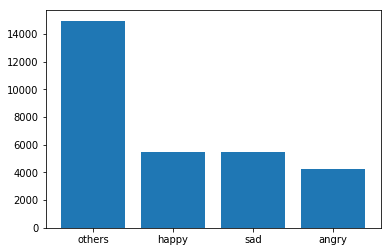

In [29]:
plt.bar(categories,category_counts,tick_label=tokens,align='center')

In [30]:
category_counts

array([14948,  5506,  5463,  4243])

In [36]:
y=np.array(y)
idx_others=np.where(y==0)[0]

In [38]:
idx = np.r_[np.random.choice(idx_others,6000),np.where(y==1)[0],np.where(y==2)[0],np.where(y==3)[0]]

In [39]:
idx.shape

(21212,)

In [40]:
deepmoji_train = deepmoji_train_all[idx]
emoji_train = emoji_train_all[idx]
y_train = y[idx]

<BarContainer object of 4 artists>

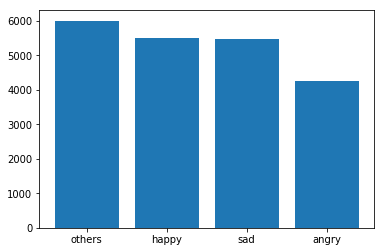

In [41]:
categories_train, category_counts_train = np.unique(y_train,return_counts=True)
plt.bar(categories_train,category_counts_train,tick_label=tokens,align='center')

In [42]:
categories_t, category_counts_t = np.unique(test_y,return_counts=True)

<BarContainer object of 4 artists>

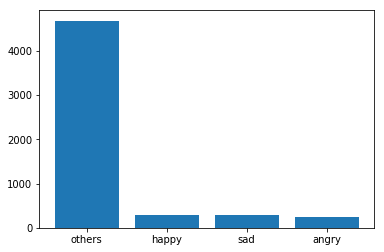

In [43]:
plt.bar(categories_t,category_counts_t,tick_label=tokens,align='center')

In [44]:
category_counts_t

array([4677,  284,  298,  250])

In [48]:
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn.linear_model import LogisticRegression

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def print_metrics(mc_prediction):
    print(metrics.classification_report(test_y, mc_prediction, target_names=tokens))
    print("Accuracy:", metrics.accuracy_score(test_y, mc_prediction))
    print("Precision:", metrics.precision_score(test_y, mc_prediction, average='macro'))
    print("Recall:", metrics.recall_score(test_y, mc_prediction, average='macro'))
    print("F1 score: ", metrics.f1_score(test_y, mc_prediction, average='macro'))
    #print("Confusion Matrix: \n", metrics.confusion_matrix(mc_Y_test, mc_prediction))
    plot_confusion_matrix(metrics.confusion_matrix(test_y, mc_prediction), tokens)

### Logistic Regression

In [55]:
LR = Pipeline([('scaler', MinMaxScaler()), ('clf', LogisticRegression(random_state=0))])
#LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

             precision    recall  f1-score   support

     others       0.98      0.83      0.89      4677
      happy       0.01      0.02      0.02       284
        sad       0.03      0.04      0.03       298
      angry       0.03      0.06      0.04       250

avg / total       0.83      0.71      0.76      5509

Accuracy: 0.7073879106915956
Precision: 0.26083199124352674
Recall: 0.237718288405168
F1 score:  0.24540443973469153
Confusion matrix, without normalization
[[3863  291  198  325]
 [  58    7   13  206]
 [  19  264   12    3]
 [  20   15  200   15]]


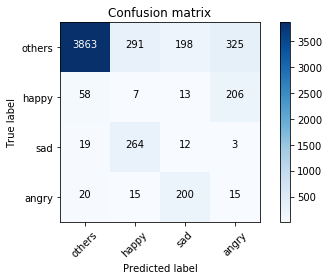

In [56]:
print_metrics(LR.predict(deepmoji_test))

In [ ]:
LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.96      0.69      0.80      4677
      happy       0.02      0.04      0.02       284
        sad       0.04      0.07      0.05       298
      angry       0.02      0.07      0.03       250

avg / total       0.82      0.60      0.69      5509

Accuracy: 0.5966600108912689
Precision: 0.2575935039537149
Recall: 0.21738158310737926
F1 score:  0.2262366613730033
Confusion matrix, without normalization
[[3238  459  395  585]
 [  70   11   11  192]
 [  27  243   21    7]
 [  41   19  173   17]]


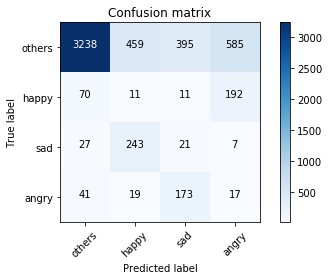

In [49]:
LR = LogisticRegression(random_state=0).fit(emoji_train, y_train) 
print_metrics(LR.predict(emoji_test))

### Naive Bayes

             precision    recall  f1-score   support

     others       0.96      0.75      0.84      4677
      happy       0.00      0.01      0.01       284
        sad       0.04      0.06      0.04       298
      angry       0.04      0.12      0.06       250

avg / total       0.82      0.64      0.72      5509

Accuracy: 0.6447631149028862
Precision: 0.26082769321563776
Recall: 0.23314868796288643
F1 score:  0.2378573442700295
Confusion matrix, without normalization
[[3503  382  279  513]
 [  70    3   10  201]
 [  26  244   17   11]
 [  34   21  166   29]]


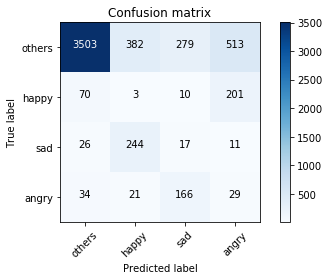

In [54]:
mc_nb = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
mc_nb.fit(deepmoji_train, y_train)
print_metrics(mc_nb.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.92      0.79      0.85      4677
      happy       0.01      0.04      0.02       284
        sad       0.04      0.06      0.04       298
      angry       0.00      0.00      0.00       250

avg / total       0.78      0.67      0.72      5509

Accuracy: 0.6718097658377201
Precision: 0.24197361478756477
Recall: 0.22118315449520243
F1 score:  0.22829869208136627
Confusion matrix, without normalization
[[3672  489  339  177]
 [ 206   10    4   64]
 [  55  224   18    1]
 [  80   20  149    1]]


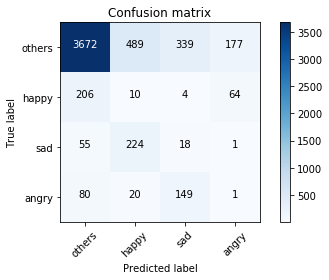

In [52]:
mc_nb = Pipeline([('clf', MultinomialNB())])
mc_nb.fit(emoji_train, y_train)
print_metrics(mc_nb.predict(emoji_test))

### SVM - One vs One

             precision    recall  f1-score   support

     others       0.96      0.74      0.84      4677
      happy       0.01      0.02      0.01       284
        sad       0.05      0.09      0.06       298
      angry       0.02      0.06      0.03       250

avg / total       0.82      0.63      0.71      5509

Accuracy: 0.6349609729533491
Precision: 0.2599238454767276
Recall: 0.2256137621252669
F1 score:  0.23494155756076057
Confusion matrix, without normalization
[[3452  431  326  468]
 [  68    6   11  199]
 [  25  242   26    5]
 [  42   19  175   14]]


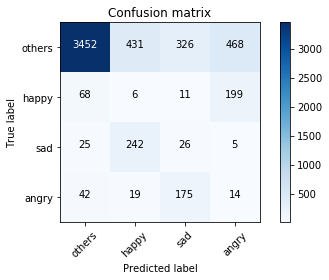

In [57]:
mc_svm_ovo = svm.SVC(decision_function_shape='ovo', kernel='linear', C=100)

mc_svm_ovo.fit(emoji_train, y_train)
print_metrics(mc_svm_ovo.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.94      0.88      0.91      4677
      happy       0.01      0.01      0.01       284
        sad       0.06      0.07      0.06       298
      angry       0.02      0.02      0.02       250

avg / total       0.81      0.75      0.78      5509

Accuracy: 0.7522236340533672
Precision: 0.2559257328877985
Recall: 0.2452590259186596
F1 score:  0.2499544328835948
Confusion matrix, without normalization
[[4115  225  173  164]
 [ 127    4    6  147]
 [  46  229   20    3]
 [  74   14  157    5]]


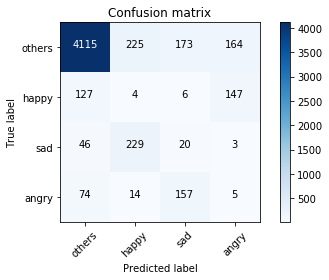

In [60]:
mc_svm_ovo = svm.SVC(decision_function_shape='ovo', kernel='linear', C=100)

mc_svm_ovo.fit(emoji_train_all, y)
print_metrics(mc_svm_ovo.predict(emoji_test))

### SVM One vs Rest

             precision    recall  f1-score   support

     others       0.96      0.74      0.84      4677
      happy       0.01      0.02      0.01       284
        sad       0.05      0.09      0.06       298
      angry       0.02      0.06      0.03       250

avg / total       0.82      0.63      0.71      5509

Accuracy: 0.6349609729533491
Precision: 0.2599238454767276
Recall: 0.2256137621252669
F1 score:  0.23494155756076057
Confusion matrix, without normalization
[[3452  431  326  468]
 [  68    6   11  199]
 [  25  242   26    5]
 [  42   19  175   14]]


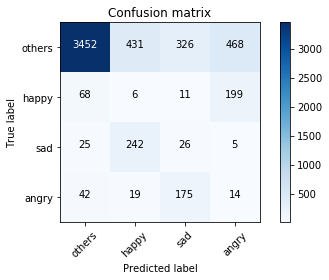

In [59]:
mc_svm_ovr = svm.SVC(decision_function_shape='ovr', kernel='linear', C=100)
mc_svm_ovr.fit(emoji_train, y_train)
print_metrics(mc_svm_ovr.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.94      0.88      0.91      4677
      happy       0.01      0.01      0.01       284
        sad       0.06      0.07      0.06       298
      angry       0.02      0.02      0.02       250

avg / total       0.81      0.75      0.78      5509

Accuracy: 0.7522236340533672
Precision: 0.2559257328877985
Recall: 0.2452590259186596
F1 score:  0.2499544328835948
Confusion matrix, without normalization
[[4115  225  173  164]
 [ 127    4    6  147]
 [  46  229   20    3]
 [  74   14  157    5]]


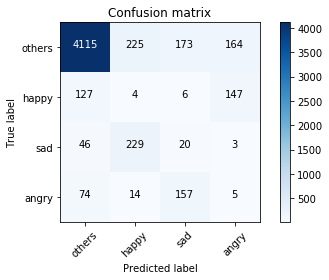

In [61]:
mc_svm_ovr = svm.SVC(decision_function_shape='ovr', kernel='linear', C=100)
mc_svm_ovr.fit(emoji_train_all, y)
print_metrics(mc_svm_ovr.predict(emoji_test))